In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tqdm
import matplotlib.pyplot as plt

train_df = pd.read_csv('/kaggle/input/how-much-would-you-pay-for-a-fake-cat/train.csv')
test_df = pd.read_csv('/kaggle/input/how-much-would-you-pay-for-a-fake-cat/test.csv')

image_dir = '/kaggle/input/part-3-resizing-our-images/resized'

def load_image_data(ids):
    image_data = []
    for img_id in tqdm.tqdm(ids):
        img_path = os.path.join(image_dir, img_id + '.png')
        im = cv2.imread(img_path)
        im = im / 255
        im = np.expand_dims(im, axis=-1)
        image_data.append(im)
    return image_data

train_images = load_image_data(train_df['id'])
test_images = load_image_data(test_df['id'])

100%|██████████| 120/120 [00:00<00:00, 211.47it/s]


In [2]:
train_input_data = np.array(train_images).astype(np.float16)
test_input_data = np.array(test_images).astype(np.float16)

In [3]:
train_df['price'] = train_df['price'].apply(lambda p: p.replace(',', ''))
train_labels = train_df['price'].values.astype(np.float16)
train_labels = np.clip(train_labels, 0, 100)
train_labels

array([ 2.13,  0.46, 10.  , ...,  1.44,  2.5 , 40.  ], dtype=float16)

In [4]:
# Lets check our dimensions
print(type(train_input_data))
print(train_input_data.shape)
print(type(train_labels))
print(train_labels.shape)

<class 'numpy.ndarray'>
(2000, 200, 200, 3, 1)
<class 'numpy.ndarray'>
(2000,)


In [5]:
# Hmmm we have an extra dimension at the end of our input data; let's investigate
train_input_data[0][0][0] # This should show us the pixel from the first image

array([[0.],
       [0.],
       [0.]], dtype=float16)

In [6]:
# We don't really need each rgb value to have it's own dimension, so we can remove that
# Keep all the                      images, rows, columns, pixels, but just the first value in each color dimension
train_input_data = train_input_data[:,      :,    :,       :,      0]
test_input_data = test_input_data[:,:,:,:,0]

In [7]:
train_input_data[0].shape

(200, 200, 3)

In [8]:
train_input_data[0][0][0] 

array([0., 0., 0.], dtype=float16)

In [9]:
train_input_data.shape

(2000, 200, 200, 3)

In [10]:
# That looks better!

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_input_data, train_labels, test_size=.2)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
# Let's test it out with our model from last time!
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_input_data, train_labels, test_size=.2)

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=256, activation='relu'),
#     tf.keras.layers.Dense(units=1)
# ])

# model.compile(loss='mean_absolute_error', optimizer='adam')
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, verbose=1)

In [13]:
# Hmmm it didn't really do all that much better; some of this can be a result of the random way we broke up our training and testing data
# Let's try mutliple different train/test splits to get a better sense of how it will perform on unseen data
from tensorflow import keras 

tf.keras.backend.clear_session()
# final_val_losses = []
# for i in range(4):
#     X_train, X_test, y_train, y_test = train_test_split(train_input_data, train_labels, test_size=.2, random_state=i)
#     tf.keras.backend.clear_session()
#     keras.utils.set_random_seed(1)
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(units=256, activation='relu'),
#         tf.keras.layers.Dense(units=1)
#     ])

#     model.compile(loss='mean_absolute_error', optimizer='adam')
#     history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, verbose=0)
#     final_val_loss = history.history['val_loss'][-1]
#     print(final_val_loss)
#     final_val_losses.append(final_val_loss)
# print('Average Val Loss:')
# print(np.mean(final_val_losses))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_input_data, train_labels, test_size=.2, random_state=1)

# Convolutions!

In [15]:
x = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0,0 ],
    [0, 0, 0, 0, 0, 0, 0, 0, 0,0 ],
]).astype(float)

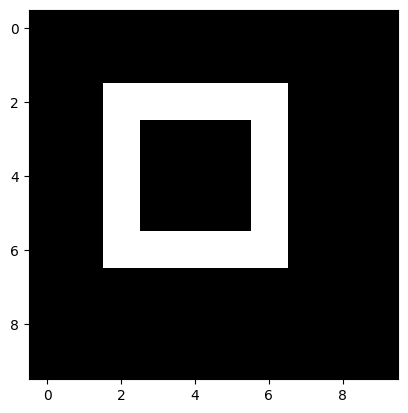

In [16]:
plt.imshow(x, cmap='gray')

In [17]:
new_x = np.array([[0] * 5]*5).astype(float)
for i in range(x.shape[0] // 2):
    for j in range(x.shape[1] // 2):
        new_value = np.mean(x[(i*2):(i*2)+2,(j*2):(j*2)+2])
        new_x[i][j] = new_value

In [18]:
new_x

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.75, 0.5 , 0.5 , 0.  ],
       [0.  , 0.5 , 0.  , 0.5 , 0.  ],
       [0.  , 0.5 , 0.5 , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

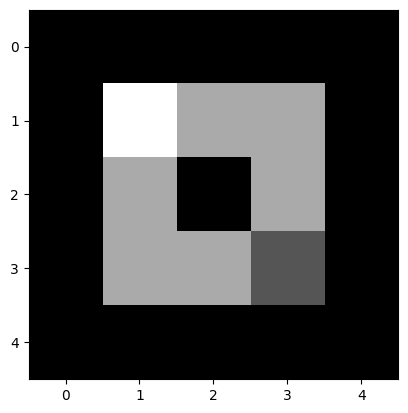

In [19]:
plt.imshow(new_x, cmap='gray')

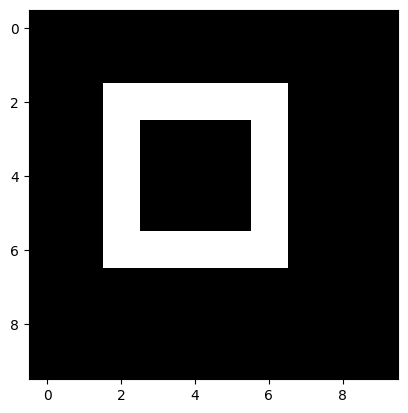

In [20]:
plt.imshow(x, cmap='gray')

In [21]:
# Right now our dense neural network kind of assumes that any two pixels are equally related
# But we know that's not true--pixels close together are more likely to share a meaningful relationship

In [22]:
tf.keras.backend.clear_session()
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu", ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

cnn_model.compile(loss='mean_absolute_error', optimizer='adam')
history = cnn_model.fit(train_input_data, train_labels, validation_data=(X_test, y_test), epochs=30, batch_size=16, verbose=1)

Epoch 1/30
125/125 [==============================] - 10s 14ms/step - loss: 11.7954 - val_loss: 12.0580
Epoch 2/30
125/125 [==============================] - 1s 8ms/step - loss: 11.4524 - val_loss: 11.5300
Epoch 3/30
125/125 [==============================] - 1s 8ms/step - loss: 11.2787 - val_loss: 11.3355
Epoch 4/30
125/125 [==============================] - 1s 8ms/step - loss: 11.1823 - val_loss: 11.2783
Epoch 5/30
125/125 [==============================] - 1s 8ms/step - loss: 11.0264 - val_loss: 11.0877
Epoch 6/30
125/125 [==============================] - 1s 8ms/step - loss: 10.9496 - val_loss: 10.6504
Epoch 7/30
125/125 [==============================] - 1s 8ms/step - loss: 10.7746 - val_loss: 10.7519
Epoch 8/30
125/125 [==============================] - 1s 8ms/step - loss: 10.7236 - val_loss: 10.6630
Epoch 9/30
125/125 [==============================] - 1s 8ms/step - loss: 10.6373 - val_loss: 10.5095
Epoch 10/30
125/125 [==============================] - 1s 8ms/step - loss: 10.63

In [23]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (16, 198, 198, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 99, 99, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (16, 78408)               0         
                                                                 
 dropout (Dropout)           (16, 78408)               0         
                                                                 
 dense (Dense)               (16, 128)                 10036352  
                                                                 
 dense_1 (Dense)             (16, 1)                   129       
                                                        

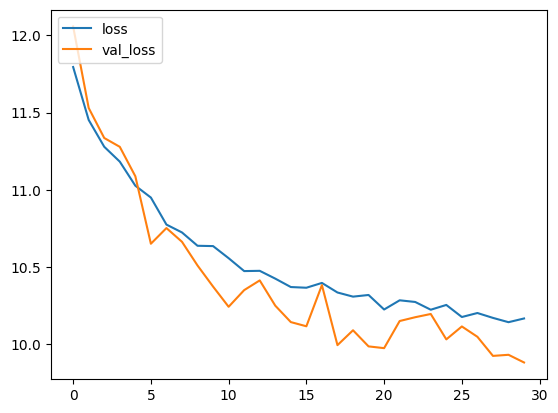

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')

In [25]:
test_df['price'] = cnn_model.predict(test_input_data)

4/4 [==============================] - 0s 19ms/step


In [26]:
submission_df = test_df[['id', 'price']]
submission_df.to_csv('submission.csv', index=False)